In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

stud = pd.read_csv('stud_math.csv')

In [2]:
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## Предобработка

In [3]:
# для удобства переименуем все столбцы с маленькой буквы
stud.rename(columns=lambda x: x.lower(), inplace=True)

# value_counts по столбцам


def value(column):
    return pd.DataFrame(stud[column].value_counts())

# информация по отдельным солбцам


def col_info(column):
    return stud.loc[:, [column]].info()

# подсчёт пропущеных значений в столбце


def col_nul(column):
    return print('Количество пропущеных значений в столбце', column, '-', stud[column].isnull().sum())

# удаление строк с пустыми значениями


def del_nul(column):
    stud.drop(np.where(stud[column].isnull())[0])
    
# график для анализа выбросов

def hist(column, l, r):
    median = stud[column].median()
    IQR = stud[column].quantile(0.75) - stud[column].quantile(0.25)
    perc25 = stud[column].quantile(0.25)
    perc75 = stud[column].quantile(0.75)
    
    stud[column].loc[stud[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10, range=(l, r),
                                                                                label='Диапазон данных без выбросов')
    stud[column].hist(alpha=0.5, bins=10, range=(l, r),
                                           label='Диапазон данных с выбросами')
    plt.legend()
    return print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

## Анализ столбца school

In [4]:
value('school')

,school
GP,349
MS,46


В столбце school пропущеных значений нет, представлена информация об учениах из двух школ, учеников из школы 'GP' почти в 9 раз больше, чем из школы 'MS'

## Анализ столбца sex

In [5]:
value('sex')

,sex
F,208
M,187


In [6]:
col_info('sex')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     395 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


В столбце sex пропущенх занчений нет, девочек немного больше, чем мальчиков

## Анализ столбца age

In [7]:
col_info('age')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

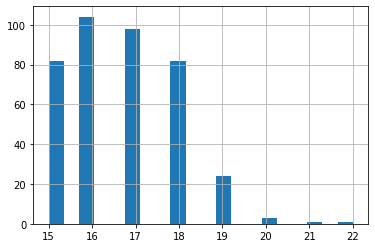

In [8]:
stud.age.hist(bins=20)
stud.age.describe()

Как видим, учащихся, возраста от 20 лет намного меньше, чем остальных возрастов, однако эти значения выбросами не являются, так как среднее значение возраста очень близко к значению медианы, посмотрим, распределение количества учеников по возрастам:

In [9]:
value('age')

,age
16,104
17,98
18,82
15,82
19,24
20,3
22,1
21,1


Учащихся, возраста от 20 до 22 лет всего 4 человека, маловато данных для того, чтобы делать какие-либо выводы... Удалим эти записи из таблицы

In [10]:
stud = stud.drop(np.where(stud['age'] >= 20)[0])

## Анализ столбца address

In [11]:
value('address')

,address
U,292
R,82


In [12]:
col_info('address')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   address  374 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


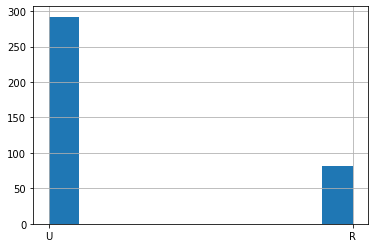

In [13]:
stud.address.hist()

In [14]:
col_nul('address')

Количество пропущеных значений в столбце address - 16


Столбец имеет 16 пропусков, заполнять мы их не будем, потому что неизвестно как это скажется на результатах нашего анализа

## Анализ столбца famsize

In [15]:
col_info('famsize')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   famsize  363 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [16]:
value('famsize')

,famsize
GT3,257
LE3,106


In [17]:
col_nul('famsize')

Количество пропущеных значений в столбце famsize - 27


Столбец имеет 27 пропусков, заполнять мы их не будем, потому что неизвестно как это скажется на результатах нашего анализа

## Анализ столбца pstatus

In [18]:
value('pstatus')

,pstatus
T,311
A,34


In [19]:
col_info('pstatus')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pstatus  345 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [20]:
col_nul('pstatus')

Количество пропущеных значений в столбце pstatus - 45


## Анализ столбца medu

In [21]:
value('medu')

,medu
4.0,130
2.0,101
3.0,95
1.0,58
0.0,3


In [22]:
col_info('medu')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   medu    387 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [23]:
col_nul('medu')

Количество пропущеных значений в столбце medu - 3


Заменим отсутствующие значения на среднее значение по столбцу

In [24]:
stud.medu = stud.medu.fillna(stud.medu.mean())

## Анализ столбца fedu

In [25]:
value('fedu')

,fedu
2.0,103
3.0,96
4.0,88
1.0,76
0.0,2
40.0,1


Значение 40, по всей видимости является значением 4, так как по условию уровень образования отца оценивается по 5 бальной системе от 0 до 4.
Заменим значение 40 на 4

In [26]:
stud.fedu = stud.fedu.apply(lambda x: 4 if x == 40 else x)

In [27]:
col_info('fedu')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    366 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [28]:
col_nul('fedu')

Количество пропущеных значений в столбце fedu - 24


Заменим отсутствующие значения на среднее значение по столбцу

In [29]:
stud.fedu = stud.fedu.fillna(stud.fedu.mean())

In [30]:
col_info('fedu')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fedu    390 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


## Анализ столбца mjob

In [31]:
value('mjob')

,mjob
other,132
services,95
at_home,58
teacher,55
health,31


In [32]:
col_info('mjob')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    371 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [33]:
col_nul('mjob')

Количество пропущеных значений в столбце mjob - 19


## Анализ столбца fjob

In [34]:
value('fjob')

,fjob
other,194
services,100
teacher,29
at_home,16
health,15


In [35]:
col_info('mjob')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   mjob    371 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [36]:
col_nul('fjob')

Количество пропущеных значений в столбце fjob - 36


## Анализ столбца reason

In [37]:
value('reason')

,reason
course,133
home,104
reputation,103
other,33


In [38]:
col_info('reason')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   reason  373 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [39]:
col_nul('reason')

Количество пропущеных значений в столбце reason - 17


## Анализ столбца guardian

In [40]:
value('guardian')

,guardian
mother,249
father,86
other,27


In [41]:
col_info('guardian')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   guardian  362 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [42]:
col_nul('guardian')

Количество пропущеных значений в столбце guardian - 28


## Анализ столбца traveltime

In [43]:
value('traveltime')

,traveltime
1.0,238
2.0,95
3.0,22
4.0,7


In [44]:
col_info('traveltime')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   traveltime  362 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [45]:
col_nul('traveltime')

Количество пропущеных значений в столбце traveltime - 28


25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


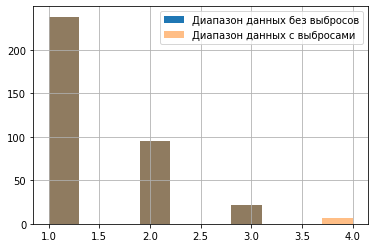

In [46]:
hist('traveltime',1,4)

## Анализ столбца studytime

In [47]:
value('studytime')

,studytime
2.0,193
1.0,100
3.0,63
4.0,27


In [48]:
col_info('studytime')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   studytime  383 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [49]:
col_nul('studytime')

Количество пропущеных значений в столбце studytime - 7


## Анализ столбца failures

In [50]:
value('failures')

,failures
0.0,292
1.0,49
2.0,14
3.0,13


In [51]:
col_info('failures')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   failures  368 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [52]:
col_nul('failures')

Количество пропущеных значений в столбце failures - 22


## Анализ столбца schoolsup 

In [53]:
value('schoolsup')

,schoolsup
no,331
yes,51


In [54]:
col_info('schoolsup')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   schoolsup  382 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [55]:
col_nul('schoolsup')

Количество пропущеных значений в столбце schoolsup - 8


## Анализ столбца famsup

In [56]:
value('famsup')

,famsup
yes,217
no,134


In [57]:
col_info('famsup')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   famsup  351 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [58]:
col_nul('famsup')

Количество пропущеных значений в столбце famsup - 39


## Анализ столбца paid 

In [59]:
value('paid')

,paid
no,197
yes,153


In [60]:
col_info('paid')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   paid    350 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [61]:
col_nul('paid')

Количество пропущеных значений в столбце paid - 40


## Анализ столбца activities

In [62]:
value('activities')

,activities
yes,194
no,182


In [63]:
col_info('activities')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  376 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [64]:
col_nul('activities')

Количество пропущеных значений в столбце activities - 14


## Анализ столбца nursery

In [65]:
value('nursery')

,nursery
yes,298
no,76


In [66]:
col_info('nursery')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   nursery  374 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [67]:
col_nul('nursery')

Количество пропущеных значений в столбце nursery - 16


## Анализ столбца higher

In [68]:
value('higher')

,higher
yes,353
no,18


In [69]:
col_info('higher')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   higher  371 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [70]:
col_nul('higher')

Количество пропущеных значений в столбце higher - 19


## Анализ столбца internet

In [71]:
value('internet')

,internet
yes,303
no,53


In [72]:
col_info('internet')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   internet  356 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [73]:
col_nul('internet')

Количество пропущеных значений в столбце internet - 34


## Анализ столбца romantic

In [74]:
value('romantic')

,romantic
no,237
yes,122


In [75]:
col_info('romantic')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   romantic  359 non-null    object
dtypes: object(1)
memory usage: 6.1+ KB


In [76]:
col_nul('romantic')

Количество пропущеных значений в столбце romantic - 31


## Анализ столбца famrel

In [77]:
value('famrel')

,famrel
4.0,182
5.0,94
3.0,62
2.0,17
1.0,7
-1.0,1


-1 заменим на 1

In [78]:
stud.famrel = stud.famrel.apply(lambda x: -1 if x == 1 else x)

In [79]:
col_info('famrel')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   famrel  363 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [80]:
col_nul('famrel')

Количество пропущеных значений в столбце famrel - 27


25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].


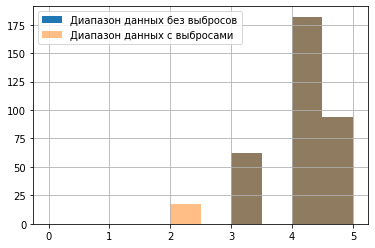

In [81]:
hist('famrel',0,5)

## Анализ столбца freetime

In [82]:
value('freetime')

,freetime
3.0,153
4.0,110
2.0,63
5.0,35
1.0,18


In [83]:
col_info('freetime')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   freetime  379 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [84]:
col_nul('freetime')

Количество пропущеных значений в столбце freetime - 11


## Анализ столбца goout

In [85]:
value('goout')

,goout
3.0,124
2.0,101
4.0,83
5.0,51
1.0,23


In [86]:
col_info('goout')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   goout   382 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [87]:
col_nul('goout')

Количество пропущеных значений в столбце goout - 8


## Анализ столбца health

In [88]:
value('health')

,health
5.0,137
3.0,87
4.0,62
1.0,46
2.0,43


In [89]:
col_info('health')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 394
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   health  375 non-null    float64
dtypes: float64(1)
memory usage: 6.1 KB


In [90]:
col_nul('health')

Количество пропущеных значений в столбце health - 15


## Анализ столбца absences 

In [91]:
value('absences')

,absences
0.0,110
2.0,60
4.0,52
6.0,31
8.0,21
10.0,17
14.0,12
12.0,12
3.0,7
7.0,6


25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


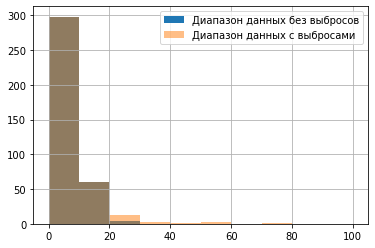

In [92]:
hist('absences', 0, 100)

Имеются выбросы в данном столбце, устраним их

In [93]:
stud = stud.loc[stud.absences <= 20]

In [94]:
col_info('absences')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 362 entries, 0 to 394
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   absences  362 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [95]:
col_nul('absences')

Количество пропущеных значений в столбце absences - 0


## Анализ столбца score

In [96]:
value('score')

,score
50.0,53
55.0,42
0.0,36
65.0,30
75.0,30
60.0,29
70.0,27
40.0,25
45.0,23
80.0,16


25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


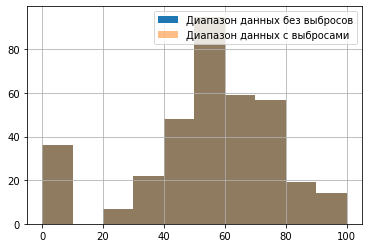

In [97]:
hist('score', 0, 100)

Выбросов нет

## Корреляционный анализ

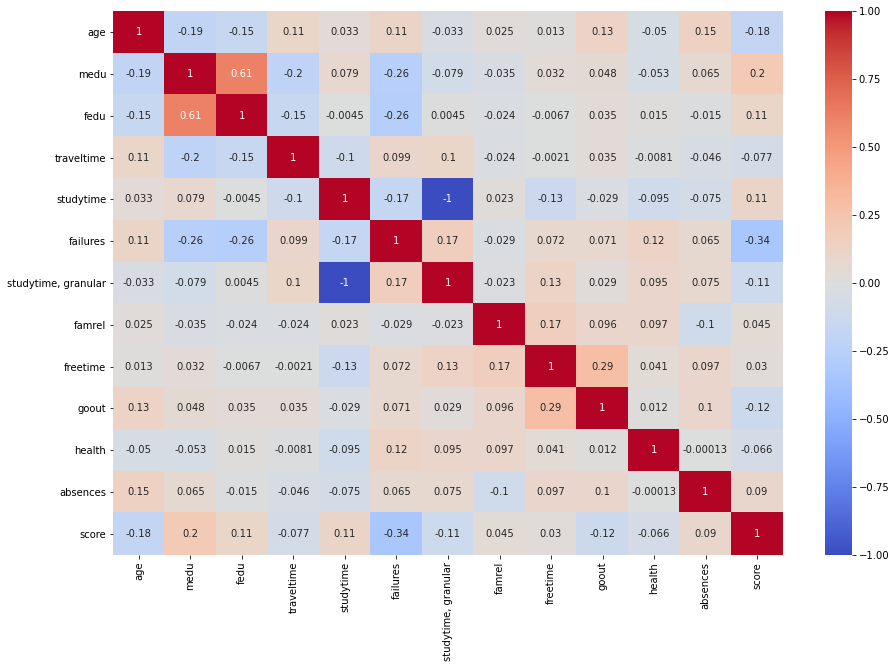

In [98]:
correlation = stud.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

Как видим полностью коррелируют столбцы studytime,granular и studytime, удалим столбец studytime,granular

In [99]:
stud.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [100]:
stud.drop(['studytime, granular'], inplace=True, axis=1)

## Анализ номинативных переменных

In [101]:
# функция для построенияя боксплота
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=stud.loc[stud.loc[:, column].isin(
                    stud.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

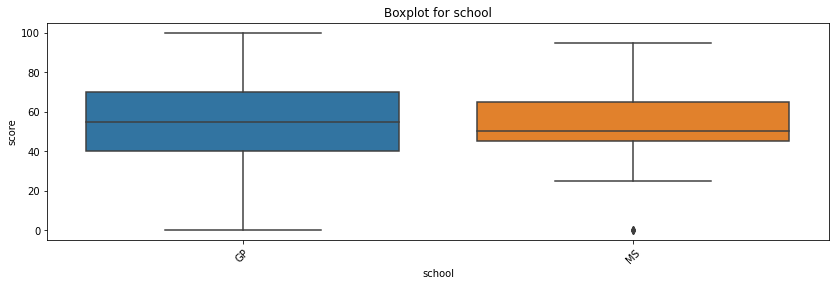

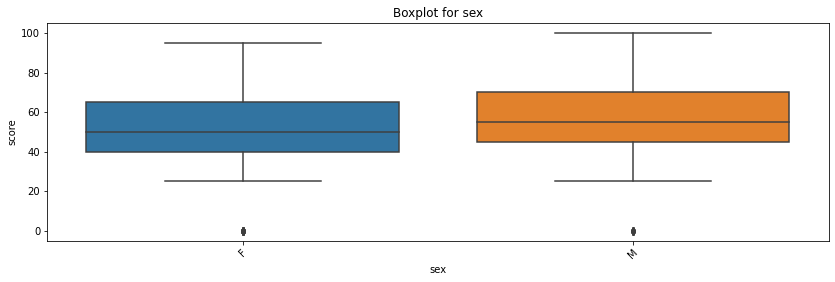

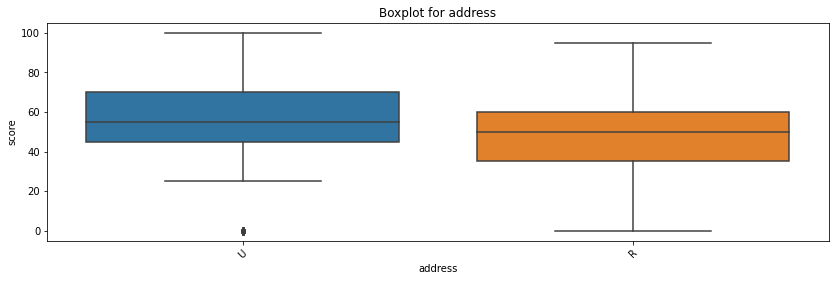

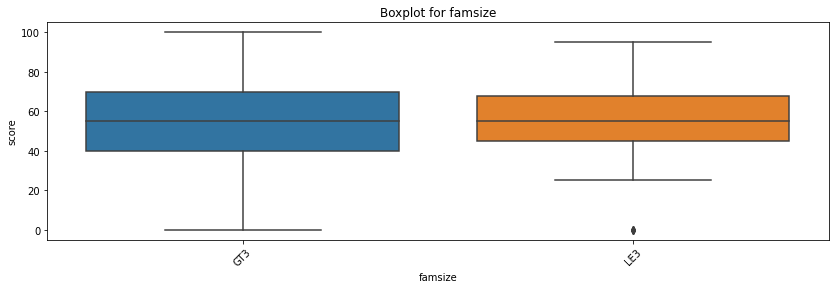

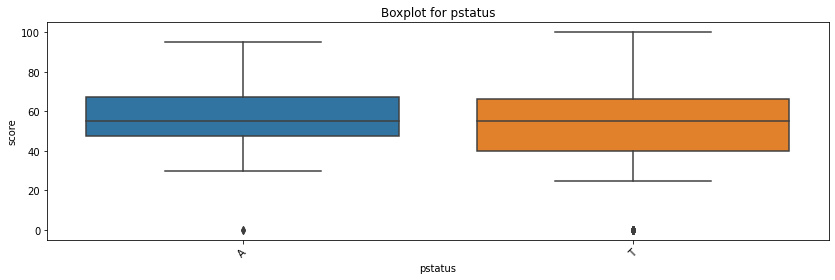

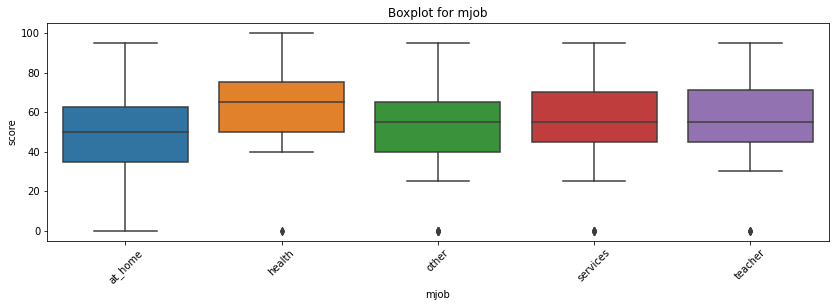

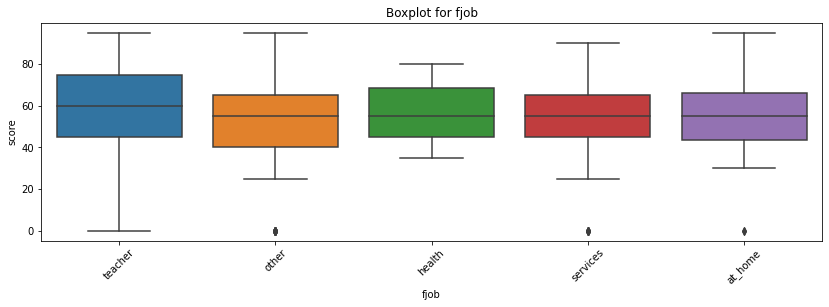

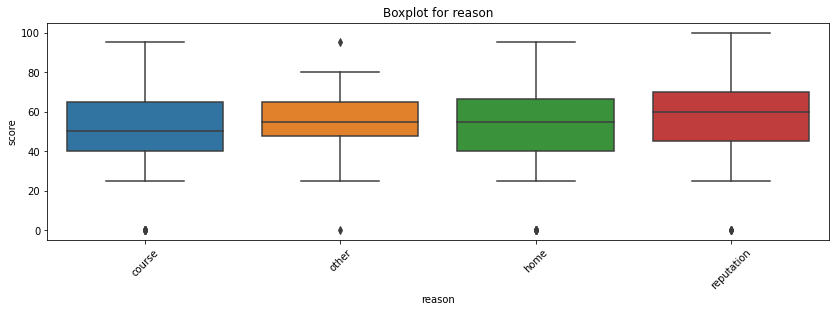

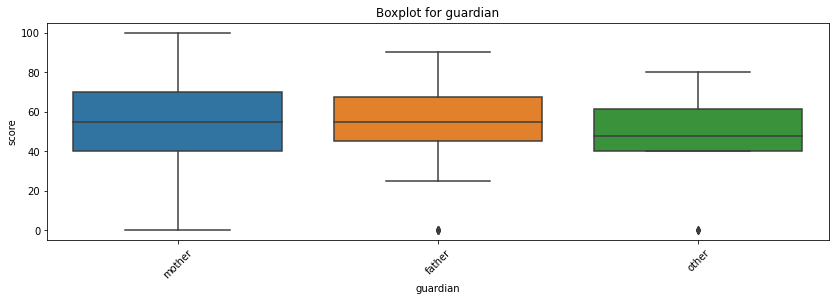

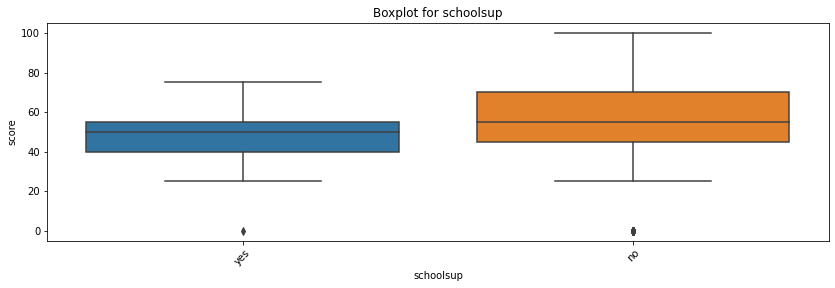

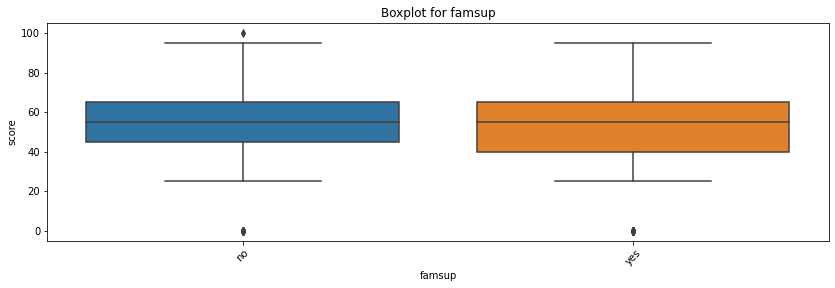

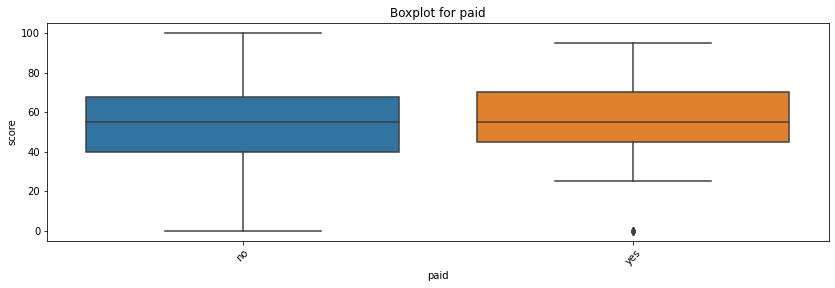

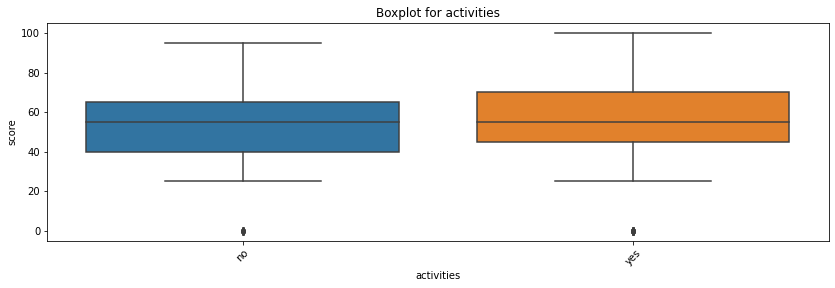

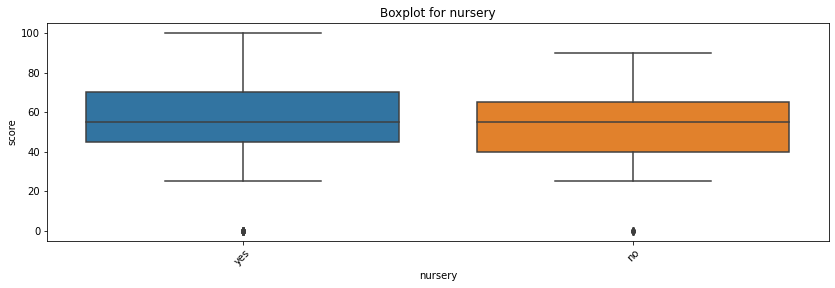

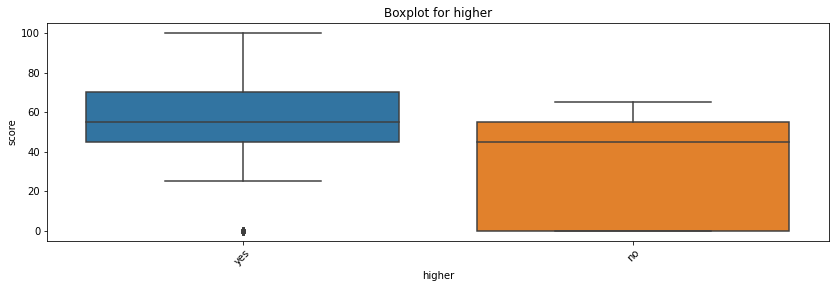

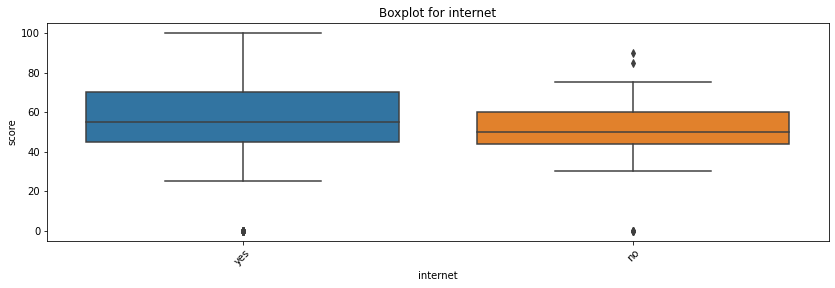

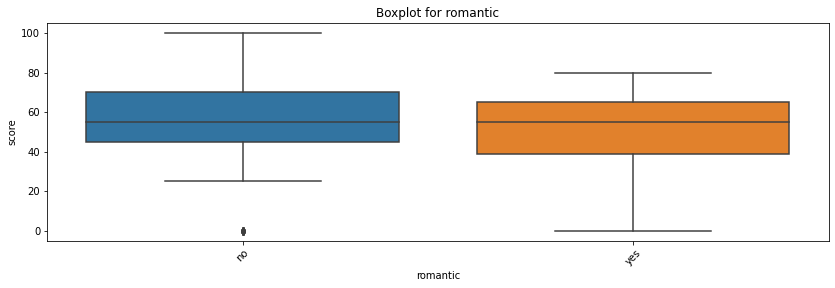

In [102]:
for col in ['school', 'sex', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_boxplot(col)

In [109]:
def get_stat_dif(column):
    cols = stud.loc[:, column].value_counts()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'], 
                        stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [110]:
for col in ['school', 'sex', 'address', 'famsize', 'pstatus', 'mjob', 'fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(col)